In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

In [34]:
rawData = pd.read_csv('data/data.scv', sep='\t')
rawData.time = pd.to_datetime(rawData.time)
rawData = rawData.set_index(rawData.time)
rawData = rawData.drop(['time'],axis=1)

In [35]:
data = rawData[['temperature.10','specHumidity.10']]['2000':'2002'].copy()

In [36]:
data.describe()

,temperature.10,specHumidity.10
count,26304.000000,26304.000000
mean,4.974434,4.927448
std,12.941322,3.235354
min,-37.020000,0.100000
25%,-4.190000,2.400000
50%,4.175000,4.000000
75%,15.890000,7.200000
max,35.170000,16.400000


In [38]:
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

In [39]:
forecasters = {}
for column in data.columns:
    forecasters[column] = Forecaster(y=data[column],current_dates= data.index)

In [40]:
for key,value in forecasters.items():
    print(key)
    print(value)

temperature.10
Forecaster(
    DateStartActuals=2000-01-01T00:00:00.000000000
    DateEndActuals=2002-12-31T23:00:00.000000000
    Freq=H
    N_actuals=26304
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=None
    GridsFile=Grids
)
specHumidity.10
Forecaster(
    DateStartActuals=2000-01-01T00:00:00.000000000
    DateEndActuals=2002-12-31T23:00:00.000000000
    Freq=H
    N_actuals=26304
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=None
    GridsFile=Grids
)


C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


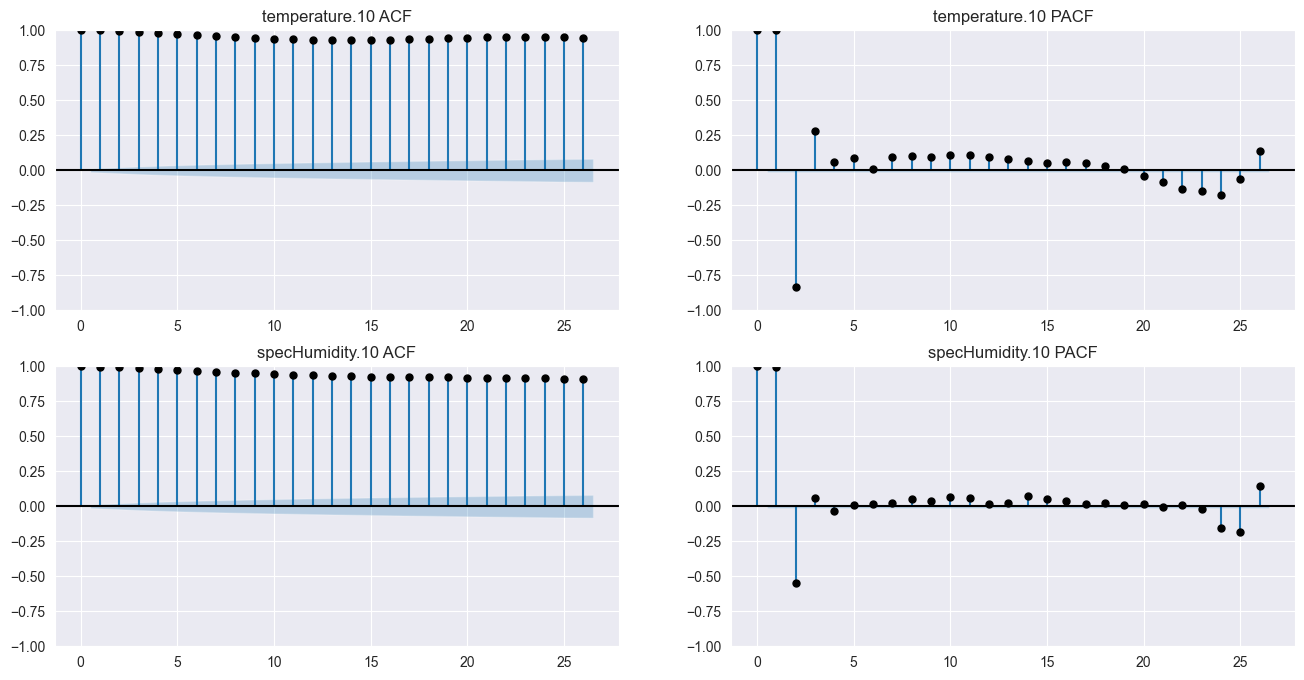

In [41]:
figs, axs = plt.subplots(data.columns.size, 2,figsize=(16,4*data.columns.size))
i = 0
for k,f in forecasters.items():

    f.plot_acf(ax=axs[i,0],title=f'{k} ACF',lags=26,color='black')
    f.plot_pacf(ax=axs[i,1],title=f'{k} PACF',lags=26,color='black')
    i+=1
plt.show()

In [42]:
for k,f in forecasters.items():
    f.generate_future_dates(12)
    f.set_test_length(.2)
    f.set_validation_length(4)
    f.add_seasonal_regressors('month',
                              'dayofyear',
                              raw=False,
                              sincos=True,
                              cycle_lens={'dayofyear':365.25}
                              )
    f.add_seasonal_regressors('year')
    f.add_time_trend()
    f.add_cycle(8768)
    f.add_ar_terms(2)

In [49]:
%time
from tqdm import tqdm

models = ['mlr','elasticnet','rf','gbt','xgboost','mlp'] #knn ломаеться почемуто......

for f in tqdm(forecasters.values()):
    f.tune_test_forecast(models,feature_importance=True)
    f.set_estimator('combo')
    f.manual_forecast(how='weighted')

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 2/2 [09:19<00:00, 279.96s/it]


C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for mlp. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for xgboost. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for gbt. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for combo. To turn on confidence intervals for future evaluated models, call the eval_cis() method.

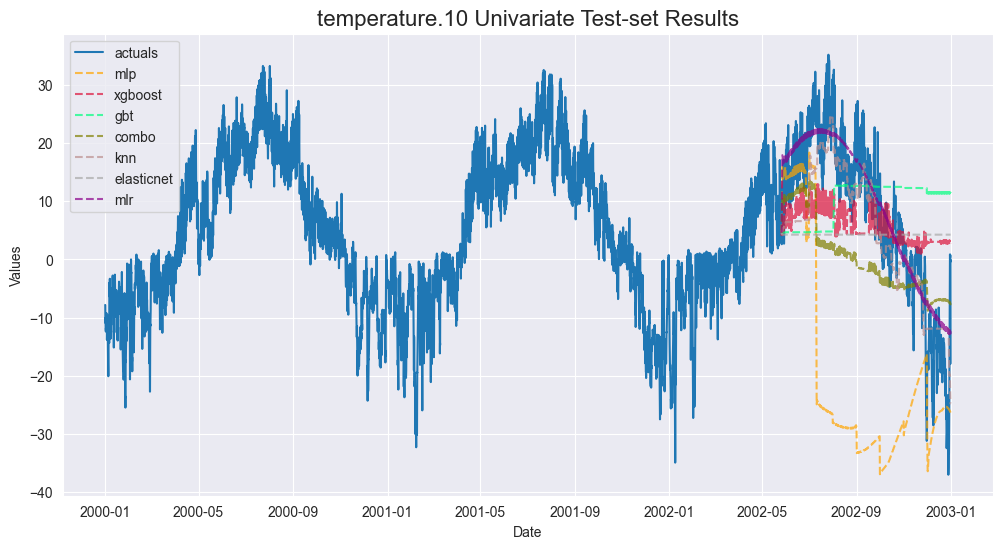

C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for mlr. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for combo. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for xgboost. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\admin\anaconda3\envs\WindDataPreparation\lib\site-packages\scalecast\Forecaster.py:5632: Warning: Confidence intervals not found for elasticnet. To turn on confidence intervals for future evaluated models, call the eval_cis() 

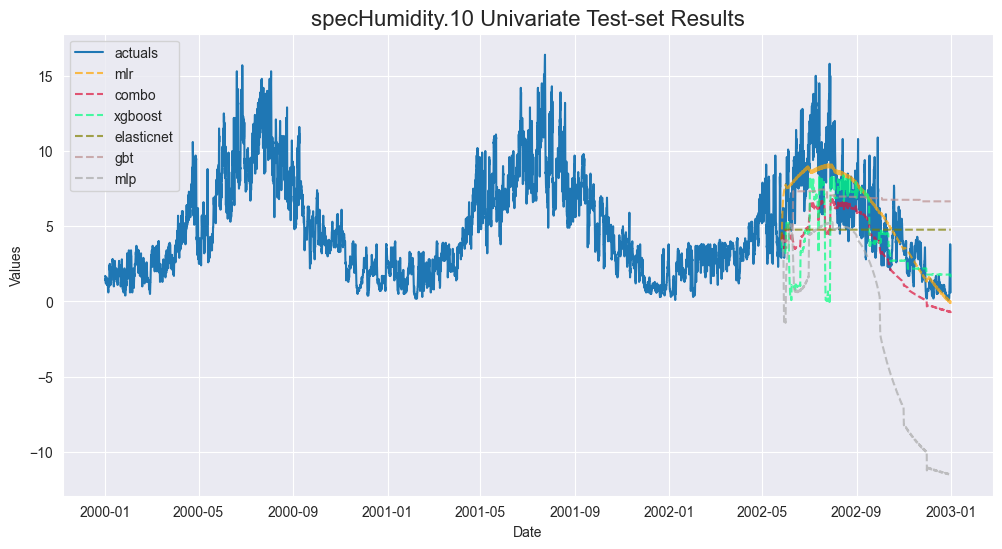

In [50]:
for k,f in forecasters.items():
    f.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
    plt.title(f'{k} Univariate Test-set Results',size=16)
    plt.show()

In [51]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries(forecasters,determine_best_by='LevelTestSetMAPE')
ms[
    [
        'ModelNickname',
        'Series',
        'Integration',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,Integration,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,best_model
0,mlp,temperature.10,0,NaN,-4.4841,NaN,0.9993,False
1,xgboost,temperature.10,0,NaN,0.2108,NaN,0.9996,False
2,gbt,temperature.10,0,NaN,-0.3207,NaN,0.9977,False
3,combo,temperature.10,0,NaN,0.1333,NaN,0.9984,False
4,knn,temperature.10,0,NaN,0.7206,NaN,0.9966,False
5,elasticnet,temperature.10,0,NaN,-0.0660,NaN,0.9749,False
6,mlr,temperature.10,0,NaN,0.8291,NaN,0.9993,True
7,mlr,specHumidity.10,0,0.3734,0.7159,0.0272,0.9970,True
8,combo,specHumidity.10,0,0.6181,0.1941,0.0630,0.9958,False
9,xgboost,specHumidity.10,0,0.6759,-0.0910,0.0230,0.9986,False


<AxesSubplot: xlabel='feature'>

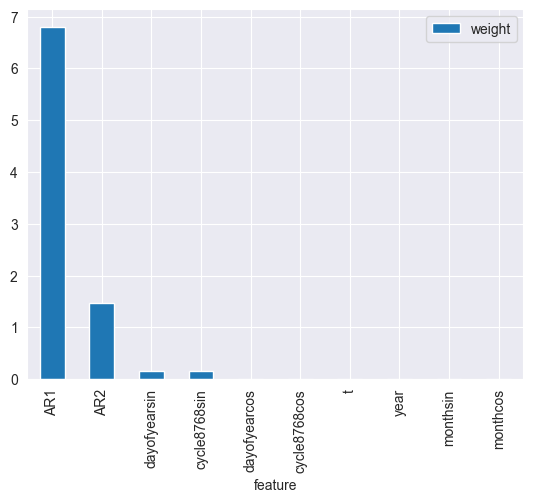

In [52]:
forecasters['temperature.10'].export_feature_importance('mlr').plot.bar(y='weight')

<AxesSubplot: xlabel='feature'>

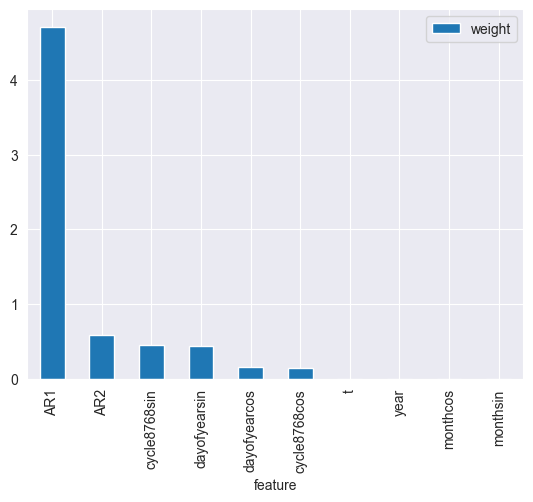

In [53]:
forecasters['specHumidity.10'].export_feature_importance('mlr').plot.bar(y='weight')

In [56]:
mvf = MVForecaster(*forecasters.values(),names=forecasters.keys()) # init the mvf object
mvf.set_test_length(.2)
mvf.set_validation_length(4)
mvf

MVForecaster(
    DateStartActuals=2000-01-01T00:00:00.000000000
    DateEndActuals=2002-12-31T23:00:00.000000000
    Freq=H
    N_actuals=26304
    N_series=2
    SeriesNames=['temperature.10', 'specHumidity.10']
    ForecastLength=12
    Xvars=['monthsin', 'monthcos', 'dayofyearsin', 'dayofyearcos', 'year', 't', 'cycle8768sin', 'cycle8768cos']
    TestLength=5260
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

In [57]:
mvf.corr()

,temperature.10,specHumidity.10
temperature.10,1.0000,0.9051
specHumidity.10,0.9051,1.0000


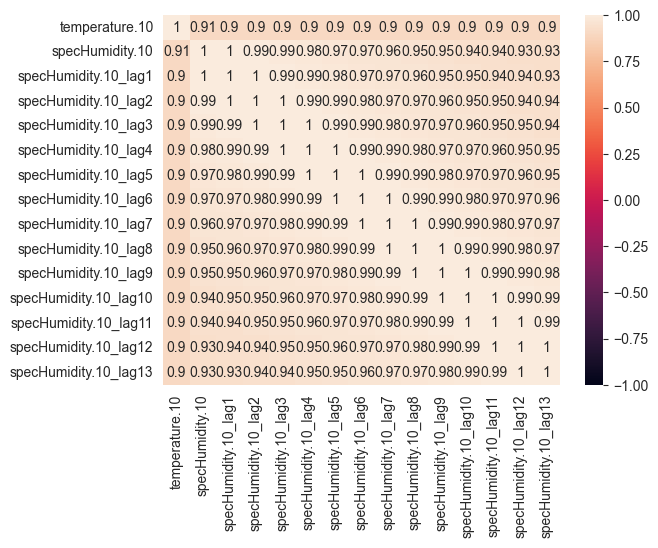

In [59]:
mvf.corr_lags(
    y='temperature.10',
    x='specHumidity.10',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
)
plt.show()

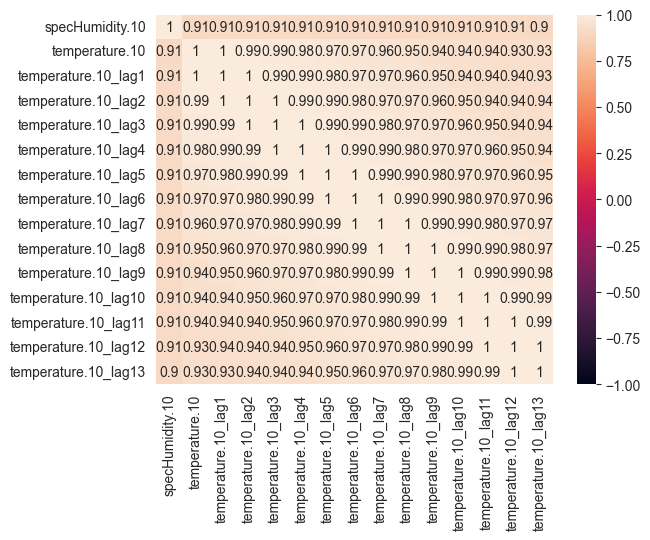

In [60]:
mvf.corr_lags(
    x='temperature.10',
    y='specHumidity.10',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
)
plt.show()

In [62]:
# how to optimize on one series
mvf.set_optimize_on('temperature.10')
# how to optimize using a weighted avarage
mvf.add_optimizer_func(lambda x: x[0]*.5 + x[1]*.5,'weighted')
mvf.set_optimize_on('weighted')
# how to optimize on the average of both/all series (default)
mvf.set_optimize_on('mean')

In [ ]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')